# Self-Driving Car Engineer Nanodegree

## Project: Vehicle Detection and Tracking

This notebook is my attempt at Project #5. The goal of this project is to write a software pipeline to dentify vehicles in a video from a front-facing camera on a car. 

---
## Step 0: Import the Useful Packages

In [1]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
import imageio
imageio.plugins.ffmpeg.download()
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import collections
from sklearn.utils import shuffle

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

---

## Step 1: Create the Dataset and Label

This is to label the data we were given.


In [2]:
#This opens a data.csv file that I created and adds the given examples of 'cars' and 'not-cars' to it
data_file = open("data.csv", 'w', newline='') #open the CSV I want to write to
writer = csv.writer(data_file)

for dirpath, dirnames, filenames in os.walk("vehicles"): #label all of the vehicle images 1
    for filename in filenames:
        fullPath = os.path.join(dirpath, filename)
        writer.writerow([fullPath, 1])

for dirpath, dirnames, filenames in os.walk("non-vehicles"): #label all of the non-vehicle images 0
    for filename in filenames:
        fullPath = os.path.join(dirpath, filename)
        writer.writerow([fullPath, 0])
        

---

## Step 2: Load the Dataset

This is to load the data we were given.


In [3]:
#This loads and splits my data into useable arrays

#array to hold the csv excel files created
lines = [] 

#open the data that was collected and store in lines
with open("data.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#arrays to store the image and their label
images = []
carOrNots = []

#load images and labels to arrays
for line in lines:
    source_path = line[0]
    image = cv2.imread(source_path)
    images.append(image)
    carOrNot = line[1]
    carOrNots.append(carOrNot)

#split up the data, use random in case I want to play with different training sets/is this a bad idea/
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(images, carOrNots, test_size=0.2, random_state=rand_state)  

#see how the split went
y_traincounts = collections.Counter(y_train)
y_testcounts = collections.Counter(y_test)

print(y_traincounts)
print(y_testcounts)


Counter({'1': 7048, '0': 7001})
Counter({'0': 1769, '1': 1744})


---

## Step 3: Choose a Colorspace and SVM

This is to pick a colorspace for my hog features to use. Just going to pick the best one after a few runs. Also, once I have a color space in place, I will do the same for an SVM (Linear or RBF probably). 


In [8]:
#Code taken and altered from lecture and quizes

# Define a function to return HOG features and visualization
def get_hog_features_chooseColor(img, orient, pix_per_cell, cell_per_block, feature_vec=True): #gets the hog features   
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_features_chooseColor(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = file
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) #cv2.COLOR_BGR2YCrCb
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features_chooseColor(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features_chooseColor(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [18]:
#test my colorspace on basic linear svm with c=1, also track time
### TODO: Tweak these parameters and see how the results change.

#X_train, y_train = shuffle(X_train, y_train) #shuffle the training data
#I test the RGB, HSV, LUV, HLS, YUV, YCrCb colorspaces for which one might work the best
#use all channels and same orient, pix, and cell from lecture
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

#Test all by changing
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

t=time.time()

X_trainHogs = extract_features_chooseColor(X_train, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

X_testHogs = extract_features_chooseColor(X_test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')



X = X_trainHogs
Xtester = X_testHogs
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
X_scalertest = StandardScaler().fit(Xtester)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
scaled_Xtest = X_scalertest.transform(Xtester)

# Define the labels vector
y = y_train
ytest = y_test

X_trained = scaled_X
X_tested = scaled_Xtest

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_trained[0]))
# Use a linear SVC or RBF
svc = SVC(C=10)#LinearSVC(C=1) #Change this to test
# Check the trainig time for the SVC
t=time.time()
svc.fit(X_trained, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_tested, ytest), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_tested[0:n_predict]))
print('For these',n_predict, 'labels: ', ytest[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

52.19 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
177.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9949
My SVC predicts:  ['0' '0' '0' '0' '1' '0' '0' '0' '1' '0']
For these 10 labels:  ['0', '0', '0', '0', '1', '0', '1', '0', '1', '0']
0.1401 Seconds to predict 10 labels with SVC


---

## Step 4: Visualize my Hog Features

Eyecandy for the writeup.


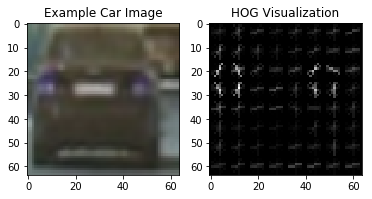

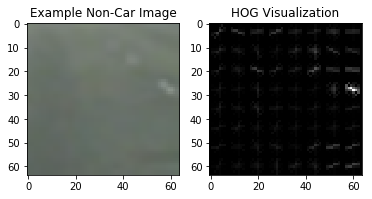

In [21]:
#hog features/dispaly hog on car and non-car
img_car = cv2.imread('vehicles/GTI_MiddleClose/image0000.png')
img_noncar = cv2.imread('non-vehicles/GTI/image1.png')

# Define a function to return HOG features and visualization
def get_hog_featuresVis(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, hog_channel=1):
    if vis == True:
        features, hog_image = hog(img[:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

gray = cv2.cvtColor(img_car, cv2.COLOR_BGR2YCrCb)
features, hog_image = get_hog_featuresVis(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

gray2 = cv2.cvtColor(img_noncar, cv2.COLOR_BGR2YCrCb)
features2, hog_image2 = get_hog_featuresVis(img_noncar, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img_noncar, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')

#print(features[0])
#print(features2)



---

## Step 5: Sliding Windows

Implement a sliding window search. 


In [ ]:


X = X_trainHogs
Xtester = X_testHogs
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
X_scalertest = StandardScaler().fit(Xtester)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
scaled_Xtest = X_scalertest.transform(Xtester)

# Define the labels vector
y = y_train
ytest = y_test

X_trained = scaled_X
X_tested = scaled_Xtest


### Split up data into randomized training and test sets
##rand_state = np.random.randint(0, 100)
##X_train, X_test, y_train, y_test = train_test_split(
##    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_trained[0]))
# Use a linear SVC 
svc = SVC(C=10)#LinearSVC(C=1)
# Check the trainig time for the SVC
t=time.time()
svc.fit(X_trained, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_tested, ytest), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_tested[0:n_predict]))
print('For these',n_predict, 'labels: ', ytest[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print(X_trained[0])

In [ ]:
#Slide a window
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = cv2.imread('test_images/test1.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)


In [ ]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [ ]:
import numpy as np
import cv2
from skimage.feature import hog
image = cv2.imread('test_images/test1.jpg')

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #print(svc.predict(test_features))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

plt.imshow(out_img)

In [ ]:
import numpy as np
import cv2
from skimage.feature import hog
image = cv2.imread('test_images/test1.jpg')

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #print(svc.predict(test_features))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

plt.imshow(out_img)

# Step 2: Example of Distortion Corrected Image

This is just to show my camera calibration worked.

In [ ]:
#read in an image and display it undistorted
#def undistortMe(img, objpoints, impoints)

def undistortMe(imgage):
    img = cv2.imread(imgage)
    dst1 = cv2.undistort(img, mtx, dist, None, mtx) #undistort the images
    dst1 = cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB) #flip back to rgb
    
    #Visualize undistortion
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #visualize rgb, looks funny without
    #dst1 = cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst1)
    ax2.set_title('Undistorted Image', fontsize=30)
    #cv2.imwrite('writeupPics/test_undist1.jpg',dst1) #save image to a file undistorted
    #cv2.imwrite('writeupPics/test_dist1.jpg',img) #save image to a file distorted
    
    return dst1



# Step 3: Thresholding

The goal below is to create a binary image result that contains, at a minimum, of where the lane lines might be.

In [ ]:
#From the color and gradient lecture, going to use sobel x and hls, s-channel
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    image = np.copy(img)
    
    #convert to HLS color space and separate the S channel
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsl[:,:,2]
    
    #grayscale the image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channelS
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(combined_binary, cmap='gray')
    ax2.set_title('Binary Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    #Visualize
    #cv2.imwrite('writeupPics/binary.jpg', combined_binary) #save image to a file distorted
    
    return combined_binary
    

# Step 4: Prespective Transform

The goal below is to create a function to give my image a "birds-eye view".

In [ ]:
#From Undistort and Transform Quiz and 'How I Did It'
def warped(img, mtx, dist):
    #get the shape
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)

    # For source points I'm grabbing the outer four detected corners from Paint
    srcs = np.float32([[581,460],[702,460],[1110,img_size[1]],[200,img_size[1]]])
    # For destination points, 
    dest = np.float32([[185,0],[1095,0],[1095,720],[185,720]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(srcs, dest)
    Minv = cv2.getPerspectiveTransform(dest, srcs)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    #get a warped image
    #top_down, Minv= warped(img, mtx, dist)

    #draw some lines on the images
    imageCopy = img.copy()
    pts = np.array([[581,460],[702,460],[1110,720],[200,720]], np.int32)
    pts = pts.reshape((-1,1,2))
    image2 = cv2.polylines(imageCopy,[pts],True,(0,255,26),5)

    top_downCopy = warped.copy()
    ptsTop = np.array([[185,0],[1095,0],[1095,720],[185,720]], np.int32)
    ptsTop = ptsTop.reshape((-1,1,2))
    top_down2 = cv2.polylines(top_downCopy,[ptsTop],True,(0,255,26),5)

    #Visualize
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(top_down2)
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    

    # Return the resulting image and matrix
    return warped, Minv




# Step 5: Curved Lines

The goal below is to identify lane-line pixels and fit their positions with a polynomial

In [ ]:
#From Implement Sliding Windows and Fit a Polynomial
# Read in a thresholded image
def curvedLinesFirst(binary_warped):
    #curvedLinesFirst.has_been_called = True
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return ploty, left_fit, right_fit, left_fitx, right_fitx


# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def curvedLinesNext(binary_warped, left_fit, right_fit):
    left_fitOld = left_fit.copy()
    right_fitOld = right_fit.copy()
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Visualize
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return ploty, left_fit, right_fit, left_fitx, right_fitx, changeInLeft, changeInRight    


# Step 6: Find Lane Curvature and Center

The goal below is to identify lane-line pixels and fit their positions with a polynomial

In [ ]:
#Taken from Lecture and Advanced Lane write-up example

def curvesandCenter(ploty, left_fit, right_fit, left_fitx, right_fitx):
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #print(left_fit) straight lines caused so much pain, not writing all of the code

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2) #changed to fitted line
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2) #changed to fitted line
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m


    #center of lane stuff, assume lane should always be in center, drift is caused by lane to shift left or right
    centerOfLanePixels = 640 #1280/2 for the image
    leftLane = left_fitx[-1] #should be the bottom
    rightLane = right_fitx[-1]
    laneWidthPixels = rightLane - leftLane #to stay positive gives lane width
    carCenterPixels = (laneWidthPixels/2) + leftLane #should be center
    carMissedByPixels = centerOfLanePixels - carCenterPixels
    carMissedByMeters = carMissedByPixels * xm_per_pix

    #print(carCenterPixels)
    #print(carMissedByPixels)
    #print(carMissedByMeters)

    rightOrLeft = ""

    if carMissedByMeters > 0: #for display purposes only
        rightOrLeft = "Left"
    else:
        rightOrLeft = "Right"
    
    carMissedByMetersABS = np.absolute(carMissedByMeters) #since we are giving a left or right
    
    return left_curverad, right_curverad, rightOrLeft, carMissedByMetersABS
      


# Step 7: Back to the Real World

The goal below is to undo everything and paint lines on an image

In [ ]:
# Create an image to draw the lines on
# From lecture and help guide

def backtoRoad(img, left_fitx, right_fitx, ploty, Minv, left_curverad, right_curverad, rightOrLeft, carMissedByMetersABS):
    img = cv2.imread(img)
    warp_zero = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result2 = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(result2,"Radius of Left Curvature: %dm" %left_curverad,(10,60), font, 2,(255,255,255),5,cv2.LINE_AA)
    cv2.putText(result2,"Radius of Right Curvature: %dm" %right_curverad,(10,125), font, 2,(255,255,255),5,cv2.LINE_AA)
    cv2.putText(result2,"Car is %0.3fm to the %s" %(carMissedByMetersABS, rightOrLeft),(10,190), font, 2,(255,255,255),5,cv2.LINE_AA)
    
    #plt.imshow(result2)
    
    return result2



# Step 8: Pipeline for Image

In [ ]:
def myPipeline(image):
    
    #make a copy
    originalImage = cv2.imread(image)
    originalImage = image #cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #flip back to rgb
    
    #distortion correction
    undistorted = undistortMe(image) #returns an undistorted rgb image
    
    #binary image
    binary = threshold(undistorted) #returns a binary image, stacked S(HLS) channel and sobel X
    
    #binary_warped
    binary_warped, Minv = warped(binary, mtx, dist)
        
    #perspective birds-eye view/check this
    ploty, left_fit, right_fit, left_fitx, right_fitx = curvedLinesFirst(binary_warped)
    
    #get curvature and center of lane info
    left_curverad, right_curverad, rightOrLeft, carMissedByMetersABS = curvesandCenter(ploty, left_fit, right_fit, left_fitx, right_fitx)
    
    #final output
    finalresult = backtoRoad(originalImage, left_fitx, right_fitx, ploty, Minv, left_curverad, right_curverad, rightOrLeft, carMissedByMetersABS)
        
    return finalresult

original = cv2.imread('test_images/test1.jpg')
hello2 = myPipeline('test_images/test1.jpg')

#Compare the start and finish
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) #flip back to rgb
hello2 = cv2.cvtColor(hello2, cv2.COLOR_BGR2RGB) #flip back to rgb
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hello2)
ax2.set_title('Finished Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)  
